In [1]:
# %%
from utils import *
from crosscoder import CrossCoder
torch.set_grad_enabled(False);

In [2]:
# Pythia19m 30vs60 checkpoint crosscoder
# repo_id: str = "victiny1223/crosscoder-checkpoints"
# currently hardcoded. need to change later.

In [3]:
# %%
repo_id = "victiny1223/crosscoder-checkpoints"

cross_coder = CrossCoder.load_from_hf()

checkpoints/version_12/5_cfg.json:   0%|          | 0.00/521 [00:00<?, ?B/s]

5.pt:   0%|          | 0.00/134M [00:00<?, ?B/s]

/home/ubuntu/crosscoders/crosscoder-model-diff-replication/crosscoder.py:201: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [4]:
# %%
norms = cross_coder.W_dec.norm(dim=-1)
norms.shape
# %%

torch.Size([4096, 2])

In [5]:
relative_norms = norms[:, 1] / norms.sum(dim=-1)
relative_norms.shape

torch.Size([4096])

# Graphing latents norm distribution and cosine similarities

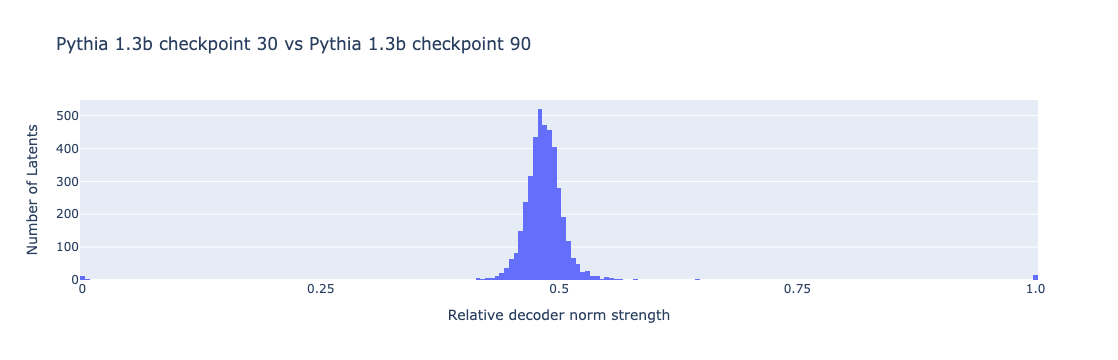

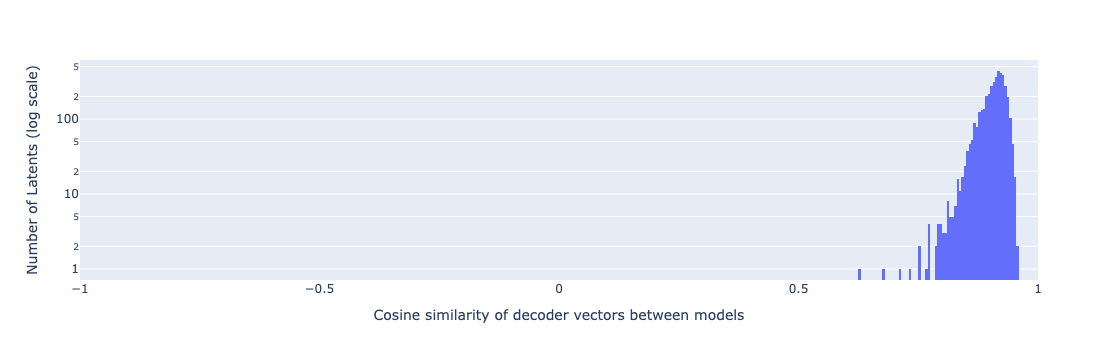

In [6]:

# %%

fig = px.histogram(
    relative_norms.detach().cpu().numpy(), 
    title="Pythia 1.3b checkpoint 30 vs Pythia 1.3b checkpoint 90",
    labels={"value": "Relative decoder norm strength"},
    nbins=200,
)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="Number of Latents")

# Update x-axis ticks
fig.update_xaxes(
    tickvals=[0, 0.25, 0.5, 0.75, 1.0],
    ticktext=['0', '0.25', '0.5', '0.75', '1.0']
)

# Display in notebook
fig.show()

# %%
shared_latent_mask = (relative_norms < 0.7) & (relative_norms > 0.3)
shared_latent_mask.shape
# %%
# Cosine similarity of recoder vectors between models

cosine_sims = (cross_coder.W_dec[:, 0, :] * cross_coder.W_dec[:, 1, :]).sum(dim=-1) / (cross_coder.W_dec[:, 0, :].norm(dim=-1) * cross_coder.W_dec[:, 1, :].norm(dim=-1))
cosine_sims.shape
# %%

fig = px.histogram(
    cosine_sims[shared_latent_mask].to(torch.float32).detach().cpu().numpy(), 
    log_y=True,  # Sets the y-axis to log scale
    range_x=[-1, 1],  # Sets the x-axis range from -1 to 1
    nbins=100,  # Adjust this value to change the number of bins
    labels={"value": "Cosine similarity of decoder vectors between models"}
)

fig.update_layout(showlegend=False)
fig.update_yaxes(title_text="Number of Latents (log scale)")

# Display in notebook
fig.show()

# %%

# Analyse the unique latents

## Maximum activating examples
Get tokens that maximally activate latent_idx
- Run a bunch of tokens, collect activations and probably cache these
- Run activations through encode in batches

In [7]:
def get_max_activating_tokens(cross_coder, model_A, model_B, tokens, latent_idx, top_k=10):
    """
    tokens: input tokens to analyze [batch, seq_len]
    latent_idx: which latent dimension to analyze
    """
    with torch.no_grad():
        # Get activations from both models
        _, cache_A = model_A.run_with_cache(tokens, names_filter="blocks.18.hook_resid_pre")
        _, cache_B = model_B.run_with_cache(tokens, names_filter="blocks.18.hook_resid_pre")
        
        # Stack activations [2, batch, seq_len, d_model]
        acts = torch.stack([
            cache_A["blocks.18.hook_resid_pre"],   
            cache_B["blocks.18.hook_resid_pre"]
        ], dim=0)

        # print(acts.shape)
        
        # Reshape to [batch*seq_len, 2, d_model]
        acts = einops.rearrange(acts, 
            "n_models batch seq_len d_model -> (batch seq_len) n_models d_model")
        
        # Get encoded activations
        encoded = cross_coder.encode(acts)  # [(batch*seq_len), d_hidden]
        
        # Get activations for specific latent
        latent_acts = encoded[:, latent_idx]
        
        # Find top activating positions
        top_values, top_indices = latent_acts.topk(top_k)
        
        # Map top_indices back to batch and sequence indices
        batch_size, seq_len = tokens.shape
        token_indices = top_indices % (batch_size * seq_len)
        batch_indices = token_indices // seq_len
        seq_indices = token_indices % seq_len
        
        return batch_indices, seq_indices, top_values

In [8]:
device = 'cuda:0'

In [9]:
# import gc

# gc.collect()

In [10]:
device = 'cuda:0'

N_1 = 30
pythia1 = HookedTransformer.from_pretrained("pythia-1.3b", checkpoint_index=N_1, device = device)


The `GPTNeoXSdpaAttention` class is deprecated in favor of simply modifying the `config._attn_implementation`attribute of the `GPTNeoXAttention` class! It will be removed in v4.48


Loaded pretrained model pythia-1.3b into HookedTransformer


In [11]:
pythia1.blocks

ModuleList(
  (0-23): 24 x TransformerBlock(
    (ln1): LayerNormPre(
      (hook_scale): HookPoint()
      (hook_normalized): HookPoint()
    )
    (ln2): LayerNormPre(
      (hook_scale): HookPoint()
      (hook_normalized): HookPoint()
    )
    (attn): Attention(
      (hook_k): HookPoint()
      (hook_q): HookPoint()
      (hook_v): HookPoint()
      (hook_z): HookPoint()
      (hook_attn_scores): HookPoint()
      (hook_pattern): HookPoint()
      (hook_result): HookPoint()
      (hook_rot_k): HookPoint()
      (hook_rot_q): HookPoint()
    )
    (mlp): MLP(
      (hook_pre): HookPoint()
      (hook_post): HookPoint()
    )
    (hook_attn_in): HookPoint()
    (hook_q_input): HookPoint()
    (hook_k_input): HookPoint()
    (hook_v_input): HookPoint()
    (hook_mlp_in): HookPoint()
    (hook_attn_out): HookPoint()
    (hook_mlp_out): HookPoint()
    (hook_resid_pre): HookPoint()
    (hook_resid_post): HookPoint()
  )
)

In [11]:
N_2 = 90
pythia2 = HookedTransformer.from_pretrained("pythia-1.3b", checkpoint_index=N_2, device = device) # commented out due to too much memory

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loaded pretrained model pythia-1.3b into HookedTransformer


### loading in latents

In [12]:
from utils import load_pile_deduped_pythia_random_sampled
test_tokens = load_pile_deduped_pythia_random_sampled()[:10240]

Loading data from disk


/home/ubuntu/crosscoders/crosscoder-model-diff-replication/utils.py:184: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [13]:
def print_token_in_context(tokens, batch_idx, seq_idx, window_size=10, model=pythia2):
    """
    Print a window of tokens around a specific token, showing maximum available context
    """
    # Get start and end indices, bounded by sequence length
    start = max(0, seq_idx - window_size)
    end = min(tokens.shape[1], seq_idx + window_size + 1)
    
    # Get the context window and target token
    context = tokens[batch_idx, start:end]
    target_token = tokens[batch_idx, seq_idx]
    
    # Get the strings
    text = model.to_string(context)
    token_str = model.to_string(target_token)
    
    # Replace whitespace with visible characters for display
    token_display = token_str.replace(' ', '␣').replace('\n', '⏎').replace('\t', '⇥')

    # Print with color
    colors = {
        'red': '\033[91m',
        'blue': '\033[94m',
        'ENDC': '\033[0m'
    }
    
    # For debugging
    print(f"{colors['blue']}Token: '{token_display}'{colors['ENDC']}")
    
    # Split into individual tokens and find the target token position
    context_tokens = [model.to_string(t) for t in context]
    relative_pos = seq_idx - start
    
    # Calculate string positions
    start_pos = sum(len(t) for t in context_tokens[:relative_pos])
    token_len = len(context_tokens[relative_pos])
    
    print(text[:start_pos] + 
          colors['red'] + text[start_pos:start_pos+token_len] + colors['ENDC'] + 
          text[start_pos+token_len:])

def analyse_max_act_tok_batched(latent_idx, batch_size=32, topk=10):
    print("-" * 50)
    print("LatentIDX:", latent_idx.item())
    
    # Lists to store results from each batch
    all_batch_indices = []
    all_seq_indices = []
    all_values = []
    
    # Process in batches
    for i in tqdm(range(0, len(test_tokens), batch_size)):
        batch_tokens = test_tokens[i:i+batch_size].to(device)
        
        # Get top k for this batch
        batch_indices, seq_indices, values = get_max_activating_tokens(
            cross_coder, pythia1, pythia2, batch_tokens, latent_idx, top_k=topk
        )
        
        # Adjust batch indices to global indices
        batch_indices = batch_indices + i
        
        # Store results
        all_batch_indices.extend(batch_indices.cpu())
        all_seq_indices.extend(seq_indices.cpu())
        all_values.extend(values.cpu())
    
    # Convert to tensors
    all_batch_indices = torch.tensor(all_batch_indices)
    all_seq_indices = torch.tensor(all_seq_indices)
    all_values = torch.tensor(all_values)
    
    # Get overall top 10
    top_k = 10
    top_indices = torch.topk(all_values, min(top_k, len(all_values)))
    final_batch_indices = all_batch_indices[top_indices.indices]
    final_seq_indices = all_seq_indices[top_indices.indices]
    
    print("\nTop activating contexts:")
    print("-" * 50)
    for i, (batch_idx, seq_idx) in enumerate(zip(final_batch_indices, final_seq_indices)):
        print(f"\n{i+1}. Value: {top_indices.values[i]:.3f}")
        print_token_in_context(test_tokens, batch_idx, seq_idx, window_size=10, model=pythia2)
    
    # Clean up memory
    torch.cuda.empty_cache()
    
    return final_batch_indices, final_seq_indices, top_indices.values

## Let's take a look at latents mostly unique to Pythia 1.3b checkpoint 90...

In [16]:
torch.cuda.empty_cache()
import gc
gc.collect()

2135

In [15]:
mask = relative_norms > 0.99
indices_0 = mask.nonzero().squeeze()
for latent_idx in indices_0:
    analyse_max_act_tok_batched(latent_idx, batch_size = 256)

--------------------------------------------------
LatentIDX: 224



00%|████████████████████████████████████████████████████████████████████████| 40/40 [03:47<00:00,  5.68s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 63.713
Token: '⏎⏎⏎⏎⏎'





                                      -8-
J-

2. Value: 63.278
Token: ''
ç¨ç¡¬ä»¶æ¯

3. Value: 59.157
Token: '⏎⏎⏎'



       In the light most favorable to the State,

4. Value: 51.577
Token: '```'
```
> ./gradlew assemble

BUILD SU

5. Value: 50.356
Token: '--'
--no matter what happens."

He'd reached

6. Value: 50.356
Token: '--'
--367) μg/g at entry vs 142 (

7. Value: 49.416
Token: '�'
�京风味小吃中�

8. Value: 47.008
Token: '‘'
‘s “Redneck Crazy,”
some radio

9. Value: 46.916
Token: '␣very'
 very fact that a Homo sapien named "Pet

10. Value: 46.916
Token: '␣very'
 very seriously, studying hard and insisting that she would prefer
--------------------------------------------------
LatentIDX: 372



00%|████████████████████████████████████████████████████████████████████████| 40/40 [03:48<00:00,  5.71s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 71.878
Token: '13'
                        13


appraisal report itself for defects under the

2. Value: 68.508
Token: '�'
�京风味小吃中�

3. Value: 65.039
Token: '␣cant'
 i said i just cant see a reason why Brazil will not win this ,

4. Value: 63.120
Token: '17'
1517, Q. Nos. 12-17) The

5. Value: 60.689
Token: '␣"'
... " "You tell me." "Elias says she

6. Value: 60.158
Token: '␣web'
Reader webInput2 = new BufferedReader( 
    

7. Value: 58.573
Token: 'NA'
NANUnion64                     = { kFloat64NA

8. Value: 58.345
Token: 'RR'
RRCConnectionRelease) message at step 270. As

9. Value: 58.345
Token: 'RR'
RRC) is Manitoba’s largest institute of

10. Value: 56.738
Token: '␣Magazine'
 Markets Magazine Micro MediaKit

Bloomberg Markets Magazine
--------------------------------------------------
LatentIDX: 550



00%|████████████████████████████████████████████████████████████████████████| 40/40 [03:48<00:00,  5.71s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 29.438
Token: '!['
--------------------------------------- ---------------------------------------

  ---------------------------------------- ----------------------------------------
   ![image](pyr_ip_v2.

2. Value: 28.083
Token: '␣\['
 does leak significant information between the flows. In Section \[

3. Value: 26.954
Token: '.'
mette l'accesso al dominio example.org e a tutti i suoi sottod

4. Value: 26.200
Token: '\['
. \[sec2\]. In Sect. \[sec3\], we show a phase diagram of

5. Value: 25.712
Token: '␣\['
 in this paper does not make this feasible. Section \[sec:formalization\] describes the Ag

6. Value: 24.638
Token: '␣(\['
{eq:var2}$$

Using equation (\[eq

7. Value: 24.569
Token: '.'
"/>

    <!-- urn:absolute:example.com/#Keyboard -->

    <owl:

8. Value: 23.931
Token: '␣receive'
International

Spend $200 or more to receive free shipping to anywhere else in the world.


9. Value: 22.981



00%|████████████████████████████████████████████████████████████████████████| 40/40 [03:48<00:00,  5.72s/it]


Top activating contexts:
--------------------------------------------------

1. Value: 73.377
Token: '⏎⏎⏎⏎⏎'





                                      -8-
J-

2. Value: 73.282
Token: '�'
�京风味小吃中�

3. Value: 71.190
Token: ''
ç¨ç¡¬ä»¶æ¯

4. Value: 69.067
Token: '⏎⏎⏎'



       In the light most favorable to the State,

5. Value: 68.977
Token: '--'
--no matter what happens."

He'd reached

6. Value: 68.977
Token: '--'
--367) μg/g at entry vs 142 (

7. Value: 67.939
Token: '```'
```
> ./gradlew assemble

BUILD SU

8. Value: 59.487
Token: '13'
                        13


appraisal report itself for defects under the

9. Value: 58.237
Token: '‘'
‘s “Redneck Crazy,”
some radio

10. Value: 56.667
Token: '␣i'
 i said i just cant see a reason why Brazil will not win
--------------------------------------------------
LatentIDX: 1208



 5%|███▋                                                                     | 2/40 [00:14<04:34,  7.21s/it]

KeyboardInterrupt: 

In [19]:
del all_encoded


In [17]:
batch_size = 256
all_encoded = []  # Store all encoded activations

for i in tqdm(range(0, len(test_tokens), batch_size)):
        batch_tokens = test_tokens[i:i+batch_size].to(device)
        
        with torch.no_grad():
            # Your existing code for running models and getting activations
            _, cache_A = pythia1.run_with_cache(batch_tokens, names_filter="blocks.18.hook_resid_pre")
            _, cache_B = pythia2.run_with_cache(batch_tokens, names_filter="blocks.18.hook_resid_pre")
            
            acts = torch.stack([
                cache_A["blocks.18.hook_resid_pre"],   
                cache_B["blocks.18.hook_resid_pre"]
            ], dim=0)
            
            acts = einops.rearrange(acts, 
                "n_models batch seq_len d_model -> (batch seq_len) n_models d_model")
            
            # Get encoded activations
            encoded = cross_coder.encode(acts)
            
            # Store batch encodings
            all_encoded.append(encoded)

# Concatenate all batches
all_encoded = torch.cat(all_encoded, dim=0)  # [(total_batch*seq_len), d_hidden]

# Now measure sparsity metrics
threshold = 1e-5
l0_sparsity = (all_encoded.abs() > threshold).float().mean() * 100
l1_norm = all_encoded.abs().mean()
dead_features = (~(all_encoded.abs() > threshold).any(dim=0)).sum()

print(f"L0 Sparsity: {l0_sparsity:.2f}% features active")
print(f"L1 Norm: {l1_norm:.3f}")
print(f"Dead features: {dead_features}")

# Plot distribution
fig = plot_activation_histogram(all_encoded)
fig.show()


00%|████████████████████████████████████████████████████████████████████████| 40/40 [03:46<00:00,  5.66s/it]

OutOfMemoryError: CUDA out of memory. Tried to allocate 10.00 GiB. GPU 0 has a total capacity of 39.38 GiB of which 6.92 GiB is free. Including non-PyTorch memory, this process has 32.45 GiB memory in use. Of the allocated memory 28.40 GiB is allocated by PyTorch, and 3.56 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [25]:
def plot_activation_histogram_split(latents):
    flat_acts = latents.flatten().cpu().numpy()
    
    fig = go.Figure()
    
    # Positive activations
    fig.add_trace(go.Histogram(
        x=flat_acts[flat_acts >= 0],
        name='Positive',
        nbinsx=50,
        marker_color='blue'
    ))
    
    # Negative activations
    fig.add_trace(go.Histogram(
        x=flat_acts[flat_acts < 0],
        name='Negative',
        nbinsx=50,
        marker_color='red'
    ))
    
    fig.update_layout(
        barmode='overlay',
        title='Latent Activation Distribution',
        xaxis_title='Activation Value',
        yaxis_title='Count'
    )
    
    return fig

In [ ]:
fig = plot_activation_histogram_split(all_encoded)
fig.show()

## now what about those latents unique to Pythia 1.3b checkpoint 30?

In [ ]:
mask = relative_norms < 0.1
indices_0 = mask.nonzero().squeeze()
for latent_idx in indices_0:
    analyse_max_act_tok_batched(latent_idx, batch_size = 256)

There may be an issue with the crosscoder in terms of its sparsity. Maybe this should be logged during the training runs?
Multiple features activating highly on vý token- so feature splitting? or just dense latents.

## Analyzing shared latents
Curious to see how these will be.

In [ ]:
mask = (relative_norms > 0.49) & (relative_norms < 0.51)
indices_0 = mask.nonzero().squeeze()
print("Shared latents: ", indices_0, " of shape ", indices_0.shape)

Let's only take the first 10 for now. There seem to be way too many latents

In [ ]:
median_latents = indices_0[:10]
for latent in median_latents:
    analyse_max_act_tok_batched(latent, batch_size = 256)

Now we can take a peak at the next 40?

In [33]:
median_latents = indices_0[10:50]
for latent in median_latents:
    analyse_max_act_tok_batched(latent, batch_size = 256)

--------------------------------------------------
LatentIDX: 21
torch.Size([2, 500, 64, 2048])
Sequence indices:  tensor([60,  3, 55, 35, 55, 18,  2,  3,  1,  0], device='cuda:0')
Batch indices:  tensor([166, 267, 231, 477, 281, 166,   0,   0,   0,   0], device='cuda:0')
Top batch tokens shape  torch.Size([10, 64])
The top 10 tokens are: 
 0 0[ 0 _0.mankab
They were found in the following batches of text [']$ is the single mode squeezing operator with real squeezing parameter $r$ and optical vacuum $|0 \\rangle$. In particular we focus on three cases, the Glauber-coherent state ($r=0$), the amplitude squeezed state ($r>0$) and the phase squeezed state ($r<0$), which,', '3) < 0)\n\nthis seems like the rational first step to the problem, since I should be replacing x with the function as no value is given for x.\n\nCan someone please explain how they came up with the 3/4 figure? And how that was used to solve the question (c)?', '\r\n"""\r\n\r\ndef reverse_sort(array):\r\n\tfor i in ran

## Top Logits Analysis

In [ ]:
def show_top_logits(
    model,
    crosscoder,
    latent_idx,
    k,
    n_models
):
    """
    Displays the top & bottom logits for a particular latent.
    """
    print('-' * 50)
    print(f'Now analyzing latent: {latent_idx.item()}')
    for model_no in range(n_models):
        logits = crosscoder.W_dec[latent_idx, model_no] @ model.W_U
    
        pos_logits, pos_token_ids = logits.topk(k)
        pos_tokens = model.to_str_tokens(pos_token_ids)
        neg_logits, neg_token_ids = logits.topk(k, largest=False)
        neg_tokens = model.to_str_tokens(neg_token_ids)
        print(
            tabulate(
                zip(map(repr, neg_tokens), neg_logits, map(repr, pos_tokens), pos_logits),
                headers = [f"Bottom tokens for model: {model_no}", "Value", "Top tokens", "Value"],
                tablefmt="simple_outline",
                stralign="right",
                numalign="left",
                floatfmt="+.3f",
            )
        )

In [ ]:
cross_coder.W_dec.shape

In [ ]:
# mask = (relative_norms > 0.49) & (relative_norms < 0.51)
mask = relative_norms < 0.1
indices_0 = mask.nonzero().squeeze()
median_latents = indices_0[:10]

from tabulate import tabulate
for latent in median_latents:
    show_top_logits(pythia1, cross_coder, latent, 10, 2)

In [ ]:
# mask = (relative_norms > 0.49) & (relative_norms < 0.51)
mask = relative_norms > 0.95
indices_0 = mask.nonzero().squeeze()
median_latents = indices_0[:10]

from tabulate import tabulate
for latent in median_latents:
    show_top_logits(pythia1, cross_coder, latent, 10, 2)

In [ ]:
mask = (relative_norms > 0.49) & (relative_norms < 0.51)
indices_0 = mask.nonzero().squeeze()
median_latents = indices_0[:10]

from tabulate import tabulate
for latent in median_latents:
    show_top_logits(pythia1, cross_coder, latent, 10, 2)

In [17]:
def untokenize_top_indices(tokenizer, tokens, top_indices):
    """
    Given a tokenizer, a batch of tokens, and top indices, return the untokenized text.
    
    tokenizer: The tokenizer used for tokenization.
    tokens: The original tokenized input data.
    top_indices: The indices of the tokens to untokenize.
    """
    # Extract the tokens corresponding to the top indices
    top_tokens = tokens[top_indices]
    
    # Convert tokens to text
    text = tokenizer.decode(top_tokens, skip_special_tokens=True)
    
    return text